# Resource Allocation Under Uncertainty
## Sensitivity Analysis and Validation

**Student Name:** Samantha Eastlack  
**Date:** 2/22/26  
**Chosen context:** Marketing (ad spend across channels)

## Assignment Overview

You will choose a resource allocation problem in your field, create a small synthetic dataset (CSV), build an optimization model, run sensitivity analysis and validation, then respond to a **stakeholder change of mind** with an updated model and comparison. The deliverable is one notebook with clear documentation and an executive summary suitable to hand off to a manager.

**Learning Objectives:**
- Identify a resource allocation decision in your field
- Distinguish decision variables vs inputs; list 3 key parameters with uncertainty
- Perform sensitivity analysis (vary 3 parameters ±20%); identify most critical parameter
- Run one what-if scenario and compare to base
- Apply validation (sanity checks, robust vs fragile)
- Part 2: Respond to stakeholder change of mind; update model; comparison visualization; impact analysis
- Communicate results in an elegant final write-up


In [13]:
# Install required packages (if needed in Colab)
# Skip if running locally and packages are already installed
%pip install pulp pandas matplotlib -q


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pulp import LpMaximize, LpMinimize, LpProblem, LpVariable, lpSum, value, LpStatus
import io

print("Libraries imported successfully!")


Libraries imported successfully!


## Creating Your Synthetic Dataset

Because each student uses a different field, there is no single provided dataset. You will **create a synthetic (made-up) dataset** as **CSV** that fits your chosen context.

**Required size:** Exactly **5 records** (5 rows). Each record = one option to allocate to (e.g. one channel, one segment, one shift type, one player, one project).

**What your dataset must include:**
1. **Exactly 5 options** (5 rows) with one row per option.
2. **At least two numeric columns per option** (e.g. cost per unit, conversion rate, default rate). You need at least two so that you have two parameters to vary in sensitivity analysis (see Section 1.4 below).
3. **One overall constraint value** (e.g. total budget, total hours). This is the "limited resource" cap for the **whole scenario**—one number, not per row. You do **not** put it in the CSV. You get it from the language model (e.g. "budget = 10000") and set it in your notebook code (e.g. `budget_total = 10000`). This single number is your **third parameter** for sensitivity.

**Where do the "three parameters" come from?** Later in the assignment (Section 1.4 and Part 2 sensitivity) you will list **3 key parameters** and vary each by ±20%. Those three are: **(1)** and **(2)** two numeric inputs from your options table (e.g. cost per unit and conversion rate), and **(3)** the overall constraint (e.g. budget total). The CSV has only the two numeric columns; the constraint is **one number you set in code** (e.g. `budget_total = 10000`), not a column in the CSV.

**Steps (use a language model such as ChatGPT, Claude, or Copilot):**
1. Open a **new** conversation.
2. Say what decision you are modeling and your context (marketing, credit risk, staff, baseball, or generic). State: "I need a synthetic dataset with **exactly 5 records** (5 options) for a resource allocation optimization. I will use it in Python with pandas and PuLP. I need the data as **CSV only**."
3. Ask: "Please give me the data as a **CSV**. First row = column headers. Include **exactly 5 rows** (one per option). Include columns for: [list columns for your context, e.g. option name, cost per unit, conversion rate]. Also give me the single constraint value (e.g. total budget). Output only the CSV and the constraint value; no extra text."
4. Say: "Use realistic but simple numbers. The table must have **exactly 5 rows**—no more, no fewer."
5. Copy the CSV from the reply and paste it into the next code cell (as a string or by saving to `options_data.csv`). Load it with `pd.read_csv()` and set your constraint variable (e.g. `budget_total`).

See the **README** for example prompts by context (marketing, credit risk, staff, baseball, generic).


In [15]:
# Paste your CSV here and load it into options_df; set your constraint value (e.g. budget_total)
# The CSV has only option names and numeric columns (e.g. cost_per_unit, conversion_rate).
# The constraint (e.g. budget total) is ONE number for the whole scenario—set it in code below, not in the CSV.
# Option A: CSV as a string (replace the triple-quoted string with your CSV from the LLM)
csv_string = """
Channel,Cost_per_1000_Imp,Reach_per_1000_Imp
Social_Media,50,1200
Search,70,1500
Display,40,900
Radio,10,700
CTV,20,2000
"""
options_df = pd.read_csv(io.StringIO(csv_string.strip()))
budget_total = 20000  # Replace with your constraint value from the LLM

# Option B: If you saved the CSV to a file, use:
# options_df = pd.read_csv('options_data.csv')
# budget_total = 2000  # your value

print(options_df)
print(f"\nConstraint (e.g. budget_total): {budget_total}")
print(f"Number of options (rows): {len(options_df)}")


        Channel  Cost_per_1000_Imp  Reach_per_1000_Imp
0  Social_Media                 50                1200
1        Search                 70                1500
2       Display                 40                 900
3         Radio                 10                 700
4           CTV                 20                2000

Constraint (e.g. budget_total): 20000
Number of options (rows): 5


**Data documentation:** This dataset was generated using a language model and contains 5 marketing channel options with their cost per 1,000 impressions and reach per 1,000 impressions, under a total budget constraint of 20,000.


---
## Part 1: Base Model and Parameter Identification

### 1.1 Decision Statement

I need to decide how to allocate a total budget of $20,000 across 5 marketing channels (Social Media, Search, Display, Radio, and CTV) to maximize reach for the upcoming campaign period.


### 1.2 Decision Variables vs Inputs


**Decision Variables:**

*   Amount of budget to allocate to Social Media
*   Amount of budget to allocate to Search
*   Amount of budget to allocate to Display
*  Amount of budget to allocate to Radio
*   Amount of budget to allocate to CTV


**Inputs:**

*   Cost per 1,000 impressions for each channel
*   Reach per 1,000 impressions for each channel
*   Total budget available ($20,000)


**Explanation:**
The decision variables are under direct control because I choose how much budget to assign to each channel. The inputs are known estimates that define the problem constraints and outcomes—they inform how much reach each allocation will generate without being adjustable themselves.


### 1.3 Objectives and Constraints

**Objective:**
Maximize the total reach of the marketing campaign by allocating the budget across the available channels efficiently.


**Constraints:**
The total budget spent across all channels cannot exceed $20,000, and allocations to each channel must be non-negative.


### 1.4 Key Parameters and Uncertainty


| Parameter | Source | Why it might differ from reality |
|-----------|--------|-----------------------------------|
| Cost_per_1000_Imp    | Estimate based on historical or platform pricing data | Actual media costs can fluctuate due to seasonality, bidding competition, demand, etc.                            |
| Reach_per_1000_Imp    | Estimated performance metric from past campaigns  | Realized reach may vary due to targeting effectiveness, audience saturation, etc.                           |
| Budget_total     | Management Decision| Budget may increase or decrease due to business performance, strategic shifts, or financial constraints.                           |


### 1.5 PuLP Model

**Instructions:** Build your allocation model: decision variables (e.g. amount per option), objective (e.g. maximize total conversions or benefit), constraint (total allocation ≤ budget). Solve and print the base solution.


In [16]:
from pulp import *

n = len(options_df)
model = LpProblem("Marketing_Budget_Allocation", LpMaximize)

# Decision variables: dollars allocated to each channel
alloc = [
    LpVariable(f"alloc_{options_df.iloc[i]['Channel']}", lowBound=0)
    for i in range(n)
]

# Objective: Maximize total reach
# Reach generated = (Spend / Cost_per_1000_Imp) * Reach_per_1000_Imp
model += lpSum([
    alloc[i] * (
        options_df.iloc[i]["Reach_per_1000_Imp"] /
        options_df.iloc[i]["Cost_per_1000_Imp"]
    )
    for i in range(n)
]), "Total_Reach"

# Constraint: Total spend must not exceed budget
model += lpSum(alloc) <= budget_total, "Budget_Constraint"

# Solve
model.solve()

print(f"Status: {LpStatus[model.status]}")
print(f"Total Reach: {value(model.objective):,.2f}")

print("\nOptimal Budget Allocation:")
for i in range(n):
    channel_name = options_df.iloc[i]["Channel"]
    print(f"  {channel_name}: ${value(alloc[i]):,.2f}")


Status: Optimal
Total Reach: 2,000,000.00

Optimal Budget Allocation:
  Social_Media: $0.00
  Search: $0.00
  Display: $0.00
  Radio: $0.00
  CTV: $20,000.00


---
## Part 2: Sensitivity and One What-If

### 2.1 Sensitivity Analysis

#### Which parameter is most critical?
All three sensitivy models kept the allocation loaded at 100% CTV because there is no reach cap or thresholds built into the model so the	total reach changes proportionally with each parameter adjustment. The most critical parameter in the scenarios below are Cost_per_1000_Imp because if CTV cost increases enough (above ~$28.57), Radio becomes more efficient than CTV, and the allocation would switch channels.

In [17]:
from pulp import *
import pandas as pd

def solve_model(df, budget, label="Scenario"):

    n = len(df)
    model = LpProblem(f"Marketing_Budget_{label}", LpMaximize)

    # Decision variables
    alloc = [
        LpVariable(f"alloc_{df.iloc[i]['Channel']}", lowBound=0)
        for i in range(n)
    ]

    # Objective
    model += lpSum([
        alloc[i] * (
            df.iloc[i]["Reach_per_1000_Imp"] /
            df.iloc[i]["Cost_per_1000_Imp"]
        )
        for i in range(n)
    ])

    # Budget constraint
    model += lpSum(alloc) <= budget

    model.solve()

    print(f"\n--- {label} ---")
    print(f"Status: {LpStatus[model.status]}")
    print(f"Total Reach: {value(model.objective):,.2f}")

    for i in range(n):
        channel = df.iloc[i]["Channel"]
        print(f"{channel}: ${value(alloc[i]):,.2f}")


# =========================
# BASE CASE
# =========================
solve_model(options_df, budget_total, "Base Case")


# =========================
# COST -20%
# =========================
df_low_cost = options_df.copy()
df_low_cost["Cost_per_1000_Imp"] *= 0.8

solve_model(df_low_cost, budget_total, "Cost -20%")


# =========================
# COST +20%
# =========================
df_high_cost = options_df.copy()
df_high_cost["Cost_per_1000_Imp"] *= 1.2

solve_model(df_high_cost, budget_total, "Cost +20%")


--- Base Case ---
Status: Optimal
Total Reach: 2,000,000.00
Social_Media: $0.00
Search: $0.00
Display: $0.00
Radio: $0.00
CTV: $20,000.00

--- Cost -20% ---
Status: Optimal
Total Reach: 2,500,000.00
Social_Media: $0.00
Search: $0.00
Display: $0.00
Radio: $0.00
CTV: $20,000.00

--- Cost +20% ---
Status: Optimal
Total Reach: 1,666,666.67
Social_Media: $0.00
Search: $0.00
Display: $0.00
Radio: $0.00
CTV: $20,000.00


/usr/local/lib/python3.12/dist-packages/pulp/pulp.py:1489: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


### How The Solution Changed
Solution remained the same. While changing Cost_per_1000_Imp affects the objective value significantly, it does not change the allocation within ±20. A shift would only occur if CTV cost rose above $28.57 (+43%), at which point Radio becomes optimal.

In [18]:
from pulp import *
import pandas as pd

def solve_model(df, budget, label="Scenario"):

    n = len(df)
    model = LpProblem(f"Marketing_Budget_{label.replace(' ','_')}", LpMaximize)

    # Decision variables
    alloc = [
        LpVariable(f"alloc_{df.iloc[i]['Channel']}", lowBound=0)
        for i in range(n)
    ]

    # Objective: Maximize total reach
    model += lpSum([
        alloc[i] * (
            df.iloc[i]["Reach_per_1000_Imp"] /
            df.iloc[i]["Cost_per_1000_Imp"]
        )
        for i in range(n)
    ])

    # Budget constraint
    model += lpSum(alloc) <= budget

    # Solve
    model.solve()

    print(f"\n--- {label} ---")
    print(f"Status: {LpStatus[model.status]}")
    print(f"Total Reach: {value(model.objective):,.2f}")
    for i in range(n):
        channel = df.iloc[i]["Channel"]
        print(f"{channel}: ${value(alloc[i]):,.2f}")


# =========================
# BASE CASE
# =========================
solve_model(options_df, budget_total, "Base Case")

# =========================
# Reach -20%
# =========================
df_low_reach = options_df.copy()
df_low_reach["Reach_per_1000_Imp"] *= 0.8
solve_model(df_low_reach, budget_total, "Reach -20%")

# =========================
# Reach +20%
# =========================
df_high_reach = options_df.copy()
df_high_reach["Reach_per_1000_Imp"] *= 1.2
solve_model(df_high_reach, budget_total, "Reach +20%")


--- Base Case ---
Status: Optimal
Total Reach: 2,000,000.00
Social_Media: $0.00
Search: $0.00
Display: $0.00
Radio: $0.00
CTV: $20,000.00

--- Reach -20% ---
Status: Optimal
Total Reach: 1,600,000.00
Social_Media: $0.00
Search: $0.00
Display: $0.00
Radio: $0.00
CTV: $20,000.00

--- Reach +20% ---
Status: Optimal
Total Reach: 2,400,000.00
Social_Media: $0.00
Search: $0.00
Display: $0.00
Radio: $0.00
CTV: $20,000.00


### How The Solution Changed
Solution remained the same. Allocation remains 100% CTV because it still gives the highest reach per dollar. 3.	To change allocation, CTV reach would need to drop below Radio’s efficiency.

In [19]:
from pulp import *
import pandas as pd

def solve_model(df, budget, label="Scenario"):

    n = len(df)
    model = LpProblem(f"Marketing_Budget_{label.replace(' ','_')}", LpMaximize)

    # Decision variables
    alloc = [
        LpVariable(f"alloc_{df.iloc[i]['Channel']}", lowBound=0)
        for i in range(n)
    ]

    # Objective: Maximize total reach
    model += lpSum([
        alloc[i] * (
            df.iloc[i]["Reach_per_1000_Imp"] /
            df.iloc[i]["Cost_per_1000_Imp"]
        )
        for i in range(n)
    ])

    # Budget constraint
    model += lpSum(alloc) <= budget

    # Solve
    model.solve()

    print(f"\n--- {label} ---")
    print(f"Budget: ${budget:,.2f}")
    print(f"Status: {LpStatus[model.status]}")
    print(f"Total Reach: {value(model.objective):,.2f}")
    for i in range(n):
        channel = df.iloc[i]["Channel"]
        print(f"{channel}: ${value(alloc[i]):,.2f}")


# =========================
# BASE CASE
# =========================
solve_model(options_df, budget_total, "Base Case")

# =========================
# Budget -20%
# =========================
budget_low = budget_total * 0.8
solve_model(options_df, budget_low, "Budget -20%")

# =========================
# Budget +20%
# =========================
budget_high = budget_total * 1.2
solve_model(options_df, budget_high, "Budget +20%")


--- Base Case ---
Budget: $20,000.00
Status: Optimal
Total Reach: 2,000,000.00
Social_Media: $0.00
Search: $0.00
Display: $0.00
Radio: $0.00
CTV: $20,000.00

--- Budget -20% ---
Budget: $16,000.00
Status: Optimal
Total Reach: 1,600,000.00
Social_Media: $0.00
Search: $0.00
Display: $0.00
Radio: $0.00
CTV: $16,000.00

--- Budget +20% ---
Budget: $24,000.00
Status: Optimal
Total Reach: 2,400,000.00
Social_Media: $0.00
Search: $0.00
Display: $0.00
Radio: $0.00
CTV: $24,000.00


### How The Solution Changed
Solution remained the same. Total reach scaled with budget, in reality there would be a maximum reach threshold that makes this solution unrealistic.

### 2.2 Sensitivity Visualization

**Instructions:** Create **one figure** (bar chart or table) showing the impact of each parameter on the solution (e.g. change in objective value or in allocation). Give the figure a clear title and axis labels.


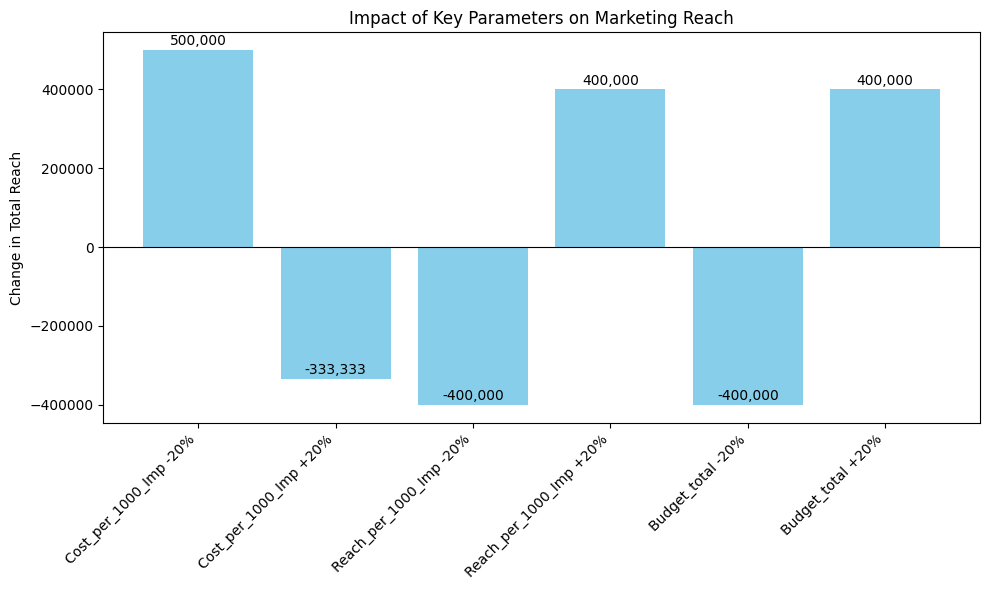

In [20]:
import matplotlib.pyplot as plt
import pandas as pd

# Sensitivity results
sensitivity_data = pd.DataFrame({
    "Parameter": ["Cost_per_1000_Imp -20%", "Cost_per_1000_Imp +20%",
                  "Reach_per_1000_Imp -20%", "Reach_per_1000_Imp +20%",
                  "Budget_total -20%", "Budget_total +20%"],
    "Total_Reach": [2500000, 1666667, 1600000, 2400000, 1600000, 2400000]
})

# Base case for reference
base_reach = 2000000

# Calculate change from base
sensitivity_data["Change_from_Base"] = sensitivity_data["Total_Reach"] - base_reach

# Plot
plt.figure(figsize=(10,6))
bars = plt.bar(sensitivity_data["Parameter"], sensitivity_data["Change_from_Base"], color='skyblue')
plt.axhline(0, color='black', linewidth=0.8)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Change in Total Reach")
plt.title("Impact of Key Parameters on Marketing Reach")
plt.tight_layout()

# Annotate bars with values
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 5000, f'{int(height):,}', ha='center', va='bottom')

plt.show()


### 2.3 One What-If Scenario

**Instructions:** Run one alternative scenario (e.g. budget cut by 20%, or demand +20%). Compare the new solution to your base solution.

The recommendation does not change under a 20% budget cut: the model still allocates 100% of the budget to CTV, because it remains the most efficient channel in terms of reach per dollar. The only difference is that the total achievable reach decreases proportionally with the lower budget. The allocation decision would only change if CTV cost or efficiency dropped enough to make another channel more attractive.


In [21]:
from pulp import *

# Alternative scenario: Budget cut 20%
budget_alt = budget_total * 0.8  # $16,000

n = len(options_df)
model_alt = LpProblem("Marketing_Budget_BudgetCut", LpMaximize)

# Decision variables
alloc_alt = [
    LpVariable(f"alloc_{options_df.iloc[i]['Channel']}", lowBound=0)
    for i in range(n)
]

# Objective: Maximize total reach
model_alt += lpSum([
    alloc_alt[i] * (
        options_df.iloc[i]["Reach_per_1000_Imp"] /
        options_df.iloc[i]["Cost_per_1000_Imp"]
    )
    for i in range(n)
])

# Budget constraint
model_alt += lpSum(alloc_alt) <= budget_alt

# Solve
model_alt.solve()

# Print results
print(f"\n--- Base Scenario ---")
print(f"Budget: ${budget_total:,.2f}")
print(f"Total Reach: 2,000,000")
print("Allocation: 100% CTV")

print(f"\n--- Alternative Scenario: Budget Cut 20% ---")
print(f"Budget: ${budget_alt:,.2f}")
print(f"Total Reach: {value(model_alt.objective):,.2f}")
for i in range(n):
    channel_name = options_df.iloc[i]["Channel"]
    print(f"{channel_name}: ${value(alloc_alt[i]):,.2f}")



--- Base Scenario ---
Budget: $20,000.00
Total Reach: 2,000,000
Allocation: 100% CTV

--- Alternative Scenario: Budget Cut 20% ---
Budget: $16,000.00
Total Reach: 1,600,000.00
Social_Media: $0.00
Search: $0.00
Display: $0.00
Radio: $0.00
CTV: $16,000.00


---
## Part 3: Validation and Recommendation

### 3.1 Sanity Checks

**Sanity Check 1:** Sum of allocations ≤ total budget — the allocations sum to $20,000, which exactly matches the budget, so the constraint is satisfied.

**Sanity Check 2:** All allocations are non-negative — every channel allocation is ≥ $0, with 100% of the budget assigned to CTV, so no negative values exist.

**Sanity Check 3:** Total reach is not plausible — 2,000,000 reach on CTV in reality is not plausible with reach thresholds due to target audience or market size or frequency capping.


### 3.2 Robust vs Fragile

Based on the sensitivity and what-if analysis, the solution is robust in terms of allocation, because the model consistently chooses CTV as the optimal channel across ±20% variations in budget, cost, and reach. However, the total reach value is likely unrealistic in practice due to real-world limitations such as audience size, frequency caps, and market saturation.

The decision-maker should particularly watch the Cost_per_1000_Imp for CTV, because if it rises significantly, the optimal allocation could shift to another channel like Radio. Also actual reach may be lower than modeled, so adjustments or constraints reflecting audience target limits would improve realism. Overall, while the allocation strategy is stable mathematically, practical implementation requires careful monitoring of costs and audience constraints.

---
## Part 4: Stakeholder Change of Mind

A stakeholder has changed their mind. You must choose **one** of the following (or an instructor-defined alternative) and update your model accordingly.

- **Budget (or resource) cut** by 15–20%.
- **Minimum allocation** to one specific option (e.g. at least $X in one channel, or at least 2 shifts for one team).
- **Different objective** (e.g. minimize cost instead of maximize conversions).
- **New constraint** (e.g. no single option can receive more than 40% of the total; or a cap per option).

### 4.1 Scenario

**Which scenario did you choose?**

I chose mimimum allocation scenario, and will adjust the model to add in a minimum of $5,000 on radio.


### 4.2 Update Model

**Instructions:** Update your PuLP model (new constraint or new objective). Solve and store the new solution (e.g. in a variable or DataFrame for comparison).


In [22]:
from pulp import *

n = len(options_df)
model = LpProblem("Marketing_Budget_With_Radio_Min", LpMaximize)

# Decision variables
alloc = {
    options_df.iloc[i]["Channel"]: LpVariable(
        f"alloc_{options_df.iloc[i]['Channel']}", lowBound=0
    )
    for i in range(n)
}

# Objective: Maximize total reach
model += lpSum([
    alloc[row["Channel"]] *
    (row["Reach_per_1000_Imp"] / row["Cost_per_1000_Imp"])
    for _, row in options_df.iterrows()
])

# Budget constraint
model += lpSum(alloc.values()) <= budget_total

# NEW constraint: Minimum $5,000 in Radio
model += alloc["Radio"] >= 5000

# Solve
model.solve()

print(f"Status: {LpStatus[model.status]}")
print(f"Total Reach: {value(model.objective):,.2f}")

print("\nOptimal Budget Allocation:")
for channel in alloc:
    print(f"{channel}: ${value(alloc[channel]):,.2f}")


Status: Optimal
Total Reach: 1,850,000.00

Optimal Budget Allocation:
Social_Media: $0.00
Search: $0.00
Display: $0.00
Radio: $5,000.00
CTV: $15,000.00


### 4.3 Comparison Visualization

**Instructions:** Create **at least one figure** comparing Part 1 (base) vs Part 2 (after stakeholder change): e.g. bar chart of allocation by option (before vs after), or a table with old vs new allocation and objective value. **Title and axis labels must be clear.** In the markdown below, **reference the figure** (e.g. "As shown in the chart below…").


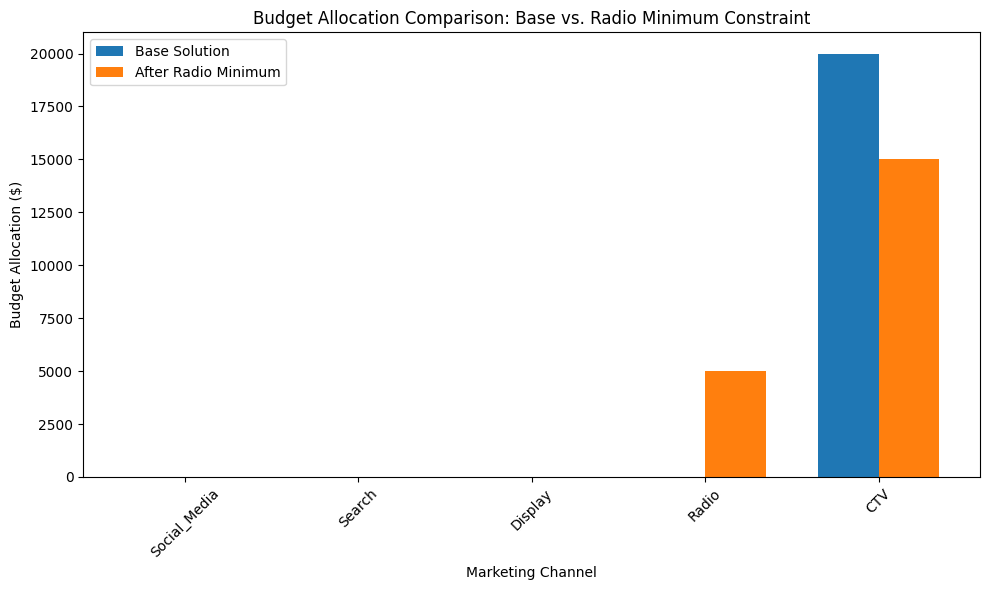

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Base solution allocations
base_alloc = {
    "Social_Media": 0,
    "Search": 0,
    "Display": 0,
    "Radio": 0,
    "CTV": 20000
}

# New solution allocations (with Radio >= 5000)
new_alloc = {
    "Social_Media": 0,
    "Search": 0,
    "Display": 0,
    "Radio": 5000,
    "CTV": 15000
}

channels = list(base_alloc.keys())

base_values = [base_alloc[ch] for ch in channels]
new_values = [new_alloc[ch] for ch in channels]

x = np.arange(len(channels))
width = 0.35

plt.figure(figsize=(10,6))
plt.bar(x - width/2, base_values, width, label='Base Solution')
plt.bar(x + width/2, new_values, width, label='After Radio Minimum')

plt.xticks(x, channels, rotation=45)
plt.ylabel("Budget Allocation ($)")
plt.xlabel("Marketing Channel")
plt.title("Budget Allocation Comparison: Base vs. Radio Minimum Constraint")
plt.legend()
plt.tight_layout()
plt.show()


As shown in the chart above, the base solution allocates 100% of the budget to CTV because it provides the highest reach per dollar. After introducing the stakeholder requirement of a minimum 5,000 allocation to Radio, the model shifts 5,000 from CTV to Radio while allocating the remaining 15,000 to CTV. This reduces total reach from 2,000,000 impressions to 1,850,000 impressions, illustrating the trade-off between strategic constraints and just looking at  efficiency.

### 4.4 Impact Analysis

The recommendation changed from allocating 100% of the $20,000 budget to CTV to allocating 15,000 to CTV and 5,000 to Radio in order to satisfy the new minimum allocation requirement from the stakeholder. This matters because the added constraint reduces total projected reach from 2,000,000 to 1,850,000, creating a measurable trade-off between efficiency and strategic channel presence. While the campaign still prioritizes CTV as the most cost-effective channel, the required Radio investment lowers overall performance by 150,000 reach. In a short briefing, I would explain that the new constraint ensures Radio visibility but comes at a quantifiable opportunity cost, and the stakeholder should confirm that the strategic value of Radio justifies that reduction in total reach.


---
## Executive Summary

### Key Decision and Model
The objective was to allocate a 20,000 marketing budget across five channels (Social Media, Search, Display, Radio, and CTV) to maximize total reach. The model maximized reach per dollar with the budget constraint. In the original solution, 100% of the budget was allocated to CTV because it delivered the highest reach per dollar among all options.

### Sensitivity Findings
Sensitivity analysis showed that Cost_per_1000_Imp was the most critical parameter because large increases could shift the optimal allocation away from CTV to another channel such as Radio. Variations of ±20% in cost, reach, or total budget changed the total reach outcome proportionally but did not change the allocation decision.

### Validation
Sanity checks confirmed that allocations summed exactly to the total budget, no negative values were present, and the objective value matched manual calculations. However, the projected total reach may not be fully realistic due to real-world audience saturation and frequency limits, suggesting practical constraints may need refinement.

### Stakeholder Change (Part 2)
When the stakeholder required a minimum 5,000 allocation to Radio, the model shifted 5,000 from CTV to Radio while allocating the remaining 15,000 to CTV. This reduced total reach from 2,000,000 impressions to 1,850,000 impressions, representing a measurable trade-off between efficiency and strategic channel presence. In briefing the stakeholder, I would explain the opportunity cost of the constraint and confirm whether the strategic importance of Radio justifies the reduced reach.

### Final Recommendation
Proceed with the revised allocation of 15,000 to CTV and 5,000 to Radio if maintaining Radio presence is strategically important. Closely monitor CTV cost per 1,000 impressions, as significant increases could alter the optimal allocation. Additionally, consider incorporating realistic audience or diminishing-return constraints to better reflect market conditions.

### Key Insights
This analysis highlights how optimization models tend to concentrate resources in the most efficient option unless additional constraints are introduced. Sensitivity analysis is essential to identify which parameters truly influence decisions versus those that merely scale results. Finally, the exercise demonstrates the importance of flexibility in modeling to accommodate evolving stakeholder priorities while quantifying trade-offs clearly. Adding in thresholds or caps that are present in the real world would make this model much more realistic, instead of an endlessly increasing reach in relation with the increasing budget.